# Data Analysis on San Francisco Bikeshare Data

## Introduction
This notebook explores a public dataset containing information on San Francisco bikeshare trip data, providing insights into usage patterns and demographics.

## Data Preparation
### Constructing the Dataset and Loading the Data

In this section, we will generate three distinct tables in BigQuery to comprehensively capture the details of the bikeshare trips, weather data, and a unified dataset that includes periods with no recorded trips. This multi-step approach ensures that we have all necessary information for thorough analysis and operational decision-making.

1. **Trip Details Table**: 
   - Captures the details of all recorded trips for every station.
   - Includes summary statistics per station per day such as trip count, average trip duration, and trip distance.

2. **Weather Details Table**: 
   - Stores weather details from the closest possible weather station for each bike station.
   - Captures key metrics such as average temperature, average windspeed, and total precipitation per day per station.

3. **Comprehensive Daily Station Data Table**: 
   - Joins trip details with weather data to create a comprehensive narrative for each station per day.
   - Adds entries for days when no trips were recorded to ensure that 0 values for trip count are present when no activity occurred.

This structured approach will provide a robust dataset for further analysis and visualization.

### SQL Queries for Dataset Construction

#### 1. Trip Details Table
The first SQL query constructs a table that aggregates trip data per station per day, including essential trip statistics.

#### 2. Weather Details Table
The second SQL query collects weather data from nearby weather stations for each bike station, summarizing daily weather conditions.

#### 3. Comprehensive Daily Station Data Table
The final SQL query joins the trip details and weather data tables, ensuring all days (including those with no trips) are represented for each station.

Let's begin by executing the SQL queries to create these tables in BigQuery.
## Data Preparation
### Constructing the Dataset and Loading the Data

In this section, we will generate three distinct tables in BigQuery to comprehensively capture the details of the bikeshare trips, weather data, and a unified dataset that includes periods with no recorded trips. This multi-step approach ensures that we have all necessary information for thorough analysis and operational decision-making.

1. **Trip Details Table**: 
   - Captures the details of all recorded trips for every station.
   - Includes summary statistics per station per day such as trip count, average trip duration, and trip distance.

2. **Weather Details Table**: 
   - Stores weather details from the closest possible weather station for each bike station.
   - Captures key metrics such as average temperature, average windspeed, and total precipitation per day per station.

3. **Comprehensive Daily Station Data Table**: 
   - Joins trip details with weather data to create a comprehensive narrative for each station per day.
   - Adds entries for days when no trips were recorded to ensure that 0 values for trip count are present when no activity occurred.

This structured approach will provide a robust dataset for further analysis and visualization.

### SQL Queries for Dataset Construction

#### 1. Trip Details Table
The first SQL query constructs a table that aggregates trip data per station per day, including essential trip statistics.

#### 2. Weather Details Table
The second SQL query collects weather data from nearby weather stations for each bike station, summarizing daily weather conditions.

#### 3. Comprehensive Daily Station Data Table
The final SQL query joins the trip details and weather data tables, ensuring all days (including those with no trips) are represented for each station.

Let's begin by executing the SQL queries to create these tables in BigQuery.


### SQL Query to Construct the Dataset
The SQL query below creates a table in BigQuery named `bikeshare_trip_data`. The query joins station data with region data to add region names to each station and then processes trip data to adjust data types, compute trip distances, and aggregate trip metrics by day and station.

#### SQL Query Explanation
- **Join Region Data with Station Data**:
  - This part of the query joins the `bikeshare_station_info` table with the `bikeshare_regions` table to add region names to each station.
  - The result is stored in the Common Table Expression (CTE) `station_data`.

- **Adjust Trip Data Types and Compute Metrics**:
  - This part of the query processes the `bikeshare_trips` table.
  - Adjusts date and time fields for easier processing and computes the day of the week and trip distance.
  - The result is stored in the CTE `bike_trips`.

- **Join Station and Trip Data**:
  - Joins the `station_data` with `bike_trips` to augment each trip with station and region information.
  - Aggregates trip metrics (e.g., trip count, average trip time, and distance) by day and station.
  - Filters out records with null region IDs and groups the data by various dimensions (e.g., date, station, region).

### SQL Query for Bike Trip Details Table


```sql
CREATE OR REPLACE TABLE `portfolio-project-429216.bikeshare_project.bikeshare_trip_data`
CLUSTER BY start_year AS

WITH
-- Join Region data with Station data to add region name as a field into the station_data CTE
  station_data AS (
  SELECT
    st.station_id,
    st.name AS station_name, 
    st.short_name,
    st.region_id,
    rg.name AS region_name,
    st.capacity AS station_capacity,
    st.has_kiosk
  FROM
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` AS st
  LEFT JOIN
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_regions` AS rg
  ON
    rg.region_id = st.region_id
  ),
-- Adjust Trip datatypes where required, adjusting id fields to strings and mutating date fields where required for easier processing
  bike_trips AS (
  SELECT
    trip_id,
    duration_sec,
    CASE
      WHEN EXTRACT(DAYOFWEEK FROM DATETIME(start_date, 'America/Los_Angeles')) = 1 THEN 7
      ELSE EXTRACT(DAYOFWEEK FROM DATETIME(start_date, 'America/Los_Angeles')) - 1
    END AS day_of_week,
    DATE(start_date, 'America/Los_Angeles') AS start_date, -- start_date initially stored as UTC timestamp
    DATE(DATE_TRUNC(start_date, YEAR)) AS start_year, -- adding a year field for data clustering to optimize storage
    CAST(start_station_id AS STRING) AS start_station_id, -- convert station_id to string for preferred data type
    DATETIME(end_date, 'America/Los_Angeles') AS end_date,
    CAST(end_station_id AS STRING) AS end_station_id,
    DATE(DATETIME(MIN(start_date) OVER (PARTITION BY CAST(start_station_id AS STRING)), 'America/Los_Angeles')) AS first_trip, -- identify earliest recorded trip date per station, which we will utilize later once all tables are joined
    DATE(DATETIME(MAX(start_date) OVER (PARTITION BY CAST(start_station_id AS STRING)), 'America/Los_Angeles')) AS last_trip, -- identify latest recorded trip date per station, which we will utilize later once all tables are joined
    bike_number,
    subscriber_type,
    member_birth_year,
    member_gender,
    bike_share_for_all_trip,
    start_station_longitude,
    start_station_latitude,
    start_station_geom,
    end_station_geom,
    ST_DISTANCE(start_station_geom, end_station_geom) AS trip_distance -- calculate trip distance in meters per trip
  FROM
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` AS bt
  )
-- Join Station and Trip data to augment information regarding each trip and aggregate trip metrics per day
SELECT
  st.region_id AS start_region_id,
  st.region_name AS start_region_name,
  bt.start_station_id,
  bt.start_station_longitude,
  bt.start_station_latitude,
  st.station_capacity AS start_station_capacity,
  bt.start_year,
  bt.start_date,
  bt.day_of_week,
  bt.first_trip,
  bt.last_trip,
  COUNT(bt.trip_id) AS trip_count,
  AVG(bt.duration_sec) AS avg_trip_time,
  AVG(bt.trip_distance) AS avg_trip_distance
FROM
  bike_trips AS bt
LEFT JOIN
  station_data AS st
ON
  bt.start_station_id = st.station_id
WHERE
  st.region_id IS NOT NULL
GROUP BY
  bt.start_year,
  bt.start_date,
  bt.day_of_week,
  bt.start_station_id,
  bt.start_station_longitude,
  bt.start_station_latitude,
  st.region_id,
  st.region_name,
  st.station_capacity,
  bt.first_trip,
  bt.last_trip


#### Weather Details Table

This SQL query constructs a table that captures weather details from the closest possible weather stations for each bike station. The query performs several key steps to ensure accurate and comprehensive weather data integration:

1. **Join Region Data with Station Data**:
   - Collects weather station data from NOAA's Global Surface Summary of the Day (GSOD) dataset.
   - Filters for weather stations in California, ensuring relevant geographical coverage.

2. **Calculate Distances**:
   - Measures the distance between each bike station and all regional weather stations.
   - Determines the closest weather station for each bike station to provide the most accurate weather data.

3. **Filter Closest Weather Stations**:
   - Uses a ranking system to identify and filter out the closest weather station for each bike station.

4. **Daily Weather Reports**:
   - Consolidates weather data from multiple years (2013-2018) to provide a comprehensive view of weather conditions.
   - Recasts default values as NULLs or appropriate placeholders to handle missing data effectively.

5. **Join and Filter Weather Reports**:
   - Joins daily weather reports with the pre-filtered list of the closest weather stations for each bike station.
   - Applies a DISTINCT statement to remove duplicate records and ensure data integrity.

6. **Final Selection**:
   - Consolidates longitude and latitude into a single geographical point for each bike station.
   - Provides a detailed view of weather conditions for each bike station, including metrics such as maximum temperature, average temperature, windspeed, and total precipitation.

This table will inform us of key weather metrics per day per station, which will later be joined with the trip details table to create a comprehensive dataset for further analysis and operational decision-making.

### SQL Query for Weather Details Table

```sql

CREATE OR REPLACE TABLE `portfolio-project-429216.bikeshare_project.bike_region_weather`
CLUSTER BY year AS

WITH
  -- Select regional stations in California
  region_stations AS (
  SELECT
    usaf,
    name,
    lon AS longitude,
    lat AS latitude,
    ST_GEOGPOINT(lon, lat) AS station_geo
  FROM
    `bigquery-public-data.noaa_gsod.stations`
  WHERE
    country = 'US'
    AND state = 'CA'
  ),
  -- Calculate the distance between each bike station and all regional weather stations
  distances AS (
  SELECT
    b.start_station_id,
    b.start_region_id,
    b.start_region_name,
    n.usaf,
    ST_DISTANCE(b.station_geo, n.station_geo) AS distance -- Measure distance between bike station and all regional stations
  FROM (
    SELECT
      t.start_station_id,
      t.start_region_id,
      t.start_region_name,
      ST_GEOGPOINT(t.start_station_longitude, t.start_station_latitude) AS station_geo
    FROM
      `portfolio-project-429216.bikeshare_project.bikeshare_trip_data` AS t
  ) b
  CROSS JOIN
    region_stations n
  WHERE
    n.usaf <> '999999' -- Exclude null station codes as per documentation
  ),
  -- Filter to select the closest NOAA station for each bike station
  noaa_station_filter AS (
  SELECT
    start_station_id,
    start_region_id,
    start_region_name,
    usaf,
    distance
  FROM (
    SELECT
      start_station_id,
      start_region_id,
      start_region_name,
      usaf,
      distance,
      ROW_NUMBER() OVER (PARTITION BY start_station_id ORDER BY distance) AS rank -- Rank distances to filter for best fit
    FROM
      distances
  )
  WHERE
    rank = 1 -- Select the closest weather station
  ),
  -- Filter bike stations and remove duplicates
  bike_station_filter AS (
  SELECT
    n.start_station_id AS bike_station_id,
    n.start_region_id AS region_id,
    n.start_region_name AS region_name,
    n.distance,
    s.*
  FROM
    noaa_station_filter AS n
  LEFT JOIN
    region_stations AS s
  ON
    n.usaf = s.usaf
  WHERE
    distance IS NOT NULL
    AND s.name NOT LIKE '%OAKLAND/METROP. OAK%' -- Exclude specific problematic station
  ),
  -- Aggregate daily weather reports from 2013-2018, converting default values to NULLs
  daily_reports AS (
  SELECT
    DISTINCT stn AS station_id,
    CAST(CONCAT(year, '-', mo, '-', da) AS DATE) AS date,
    IF(CAST(wdsp AS FLOAT64) = 999.9, NULL, CAST(wdsp AS FLOAT64)) AS windspeed,
    IF(TEMP = 9999.9, NULL, TEMP) AS avg_temp,
    IF(max = 9999.9, NULL, max) AS max_temp,
    IF(prcp = 99.99, 0.0, prcp) AS total_precipitation
  FROM (
    SELECT * FROM `bigquery-public-data.noaa_gsod.gsod2013`
    UNION ALL
    SELECT * FROM `bigquery-public-data.noaa_gsod.gsod2014`
    UNION ALL
    SELECT * FROM `bigquery-public-data.noaa_gsod.gsod2015`
    UNION ALL
    SELECT * FROM `bigquery-public-data.noaa_gsod.gsod2016`
    UNION ALL
    SELECT * FROM `bigquery-public-data.noaa_gsod.gsod2017`
    UNION ALL
    SELECT * FROM bigquery-public-data.noaa_gsod.gsod2018
  )
  ),
  -- Join the daily weather reports with the filtered station data
  station_reports AS (
  SELECT
    DISTINCT rs.region_name,
    rs.region_id,
    rs.usaf,
    rs.bike_station_id,
    rs.longitude,
    rs.latitude,
    dr.date,
    DATE_TRUNC(dr.date, YEAR) AS year,
    dr.max_temp,
    dr.avg_temp,
    dr.windspeed,
    dr.total_precipitation
  FROM
    bike_station_filter AS rs
  LEFT JOIN
    daily_reports AS dr
  ON
    dr.station_id = rs.usaf
  WHERE
    dr.date IS NOT NULL
  )
-- Final SELECT statement to create the consolidated table
SELECT
  region_name,
  region_id,
  usaf,
  bike_station_id,
  ST_GEOGPOINT(longitude, latitude) AS station_geo,
  date,
  year,
  max_temp,
  avg_temp,
  windspeed,
  total_precipitation
FROM
  station_reports


## Constructing the Final Dataset

### Introduction

This section describes the process of creating a comprehensive dataset that combines bikeshare trip data, weather data, and additional calculated features. The goal is to generate a complete dataset that covers all possible dates for each station, including days with no trips, and to provide meaningful metrics that can be used for further analysis and modeling.

### Steps

1. **Generate Date Array**:
   - Create a table of all dates within the range from `2013-01-01` to `2018-12-31`.
   - Extract the day of the week, month, quarter, and year from each date.

2. **Create All Possible Dates for Each Station**:
   - Generate a table of all possible dates for each station, including days with no trips.
   - Calculate the operational day since the first recorded trip for each station.
   - Initialize trip count to 0 for all dates.

3. **Aggregate and Calculate Metrics**:
   - Merge the generated dates with the trip data to fill in days with actual trip counts where available.
   - Calculate various metrics, including:
     - Average daily trips per month.
     - Average trips for each day of the week per month.
     - Previous week's trip count.
     - Rolling 14-day average trip count.
     - Weather-related metrics such as average temperature, maximum temperature, total precipitation, and windspeed.
     - Cumulative distribution metrics for weather variables to capture relative conditions within each region.

### SQL Code


```sql
CREATE OR REPLACE TABLE portfolio-project-429216.bikeshare_project.bikeshare_data_complete 
CLUSTER BY year AS

WITH
  -- Create a table of all dates within the given range (2013-01-01 to 2018-12-31)
  empty_dates AS (
  SELECT
    DISTINCT day,
    -- Extract the day of the week starting from Monday (1) to Sunday (7)
    CASE
      WHEN EXTRACT(DAYOFWEEK FROM day) = 1 THEN 7
      ELSE EXTRACT(DAYOFWEEK FROM day) - 1
    END AS day_of_week,
    -- Extract the month from the date
    EXTRACT(MONTH FROM day) AS month,
    -- Extract the quarter from the date
    EXTRACT(QUARTER FROM day) AS quarter,
    -- Extract the year from the date and truncate to the start of the year
    DATE_TRUNC(day, YEAR) AS year
  FROM
    -- Generate a date array from 2013-01-01 to 2018-12-31
    UNNEST(GENERATE_DATE_ARRAY('2013-01-01', '2018-12-31')) AS day
  ORDER BY
    day
  ),
  -- Create a table of all possible dates for each station, including days with no trips
  all_dates AS (
  SELECT
    DISTINCT t.start_region_id,
    t.start_station_id,
    d.year,
    d.month,
    d.quarter,
    d.day AS date,
    -- Calculate the operational day since the first trip
    DATE_DIFF(d.day, DATE_SUB(t.first_trip, INTERVAL 1 DAY), DAY) AS operation_day,
    d.day_of_week,
    -- Initialize trip count to 0 for all dates
    0 AS trip_count
  FROM
    `portfolio-project-429216.bikeshare_project.bikeshare_trip_data` t,
    empty_dates d
  WHERE
    d.day >= t.first_trip
    AND d.day <= t.last_trip
  )
-- Select and aggregate data to create the final dataset
SELECT
  a.start_region_id,
  a.start_station_id,
  a.year,
  a.month,
  -- Calculate the average daily trips for each station per month
  AVG(IFNULL(t.trip_count, a.trip_count)) OVER (PARTITION BY a.start_station_id, a.year, a.month) AS avg_month_daily_trips,
  a.quarter,
  a.date,
  a.operation_day,
  a.day_of_week,
  -- Use actual trip count if available, otherwise use 0 (from all_dates)
  IFNULL(t.trip_count, a.trip_count) AS trip_count,
  t.avg_trip_distance,
  t.avg_trip_time,
  -- Calculate the average trips for each station for each day of the week per month
  AVG(IFNULL(t.trip_count, a.trip_count)) OVER (PARTITION BY a.start_station_id, a.month, a.day_of_week) AS avg_dow_trips,
  -- Calculate the previous week's trip count for each station
  LAG(IFNULL(t.trip_count, a.trip_count), 7) OVER (PARTITION BY a.start_station_id ORDER BY a.date) AS prev_dow_trip_count,
  -- Calculate the rolling 14-day average trip count for each station
  SUM(IFNULL(t.trip_count, a.trip_count)) OVER (PARTITION BY a.start_station_id ORDER BY a.date ASC ROWS BETWEEN 13 PRECEDING AND CURRENT ROW) / 
  COUNT(a.date) OVER (PARTITION BY a.start_station_id ORDER BY a.date ASC ROWS BETWEEN 13 PRECEDING AND CURRENT ROW) AS rolling_14_day_avg,
  w.avg_temp,
  -- Calculate the cumulative distribution for average temperature within each region
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.avg_temp) AS avg_temp_dist,
  w.max_temp,
  -- Calculate the cumulative distribution for maximum temperature within each region
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.max_temp) AS max_temp_dist,
  w.total_precipitation,
  -- Calculate the cumulative distribution for total precipitation within each region in descending order
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.total_precipitation DESC) AS precipitation_dist,
  w.windspeed,
  -- Calculate the cumulative distribution for windspeed within each region in descending order
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.windspeed DESC) AS windspeed_dist,
  -- Calculate the interaction of weather conditions for each region
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.avg_temp) * 
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.total_precipitation DESC) *
  CUME_DIST() OVER (PARTITION BY a.start_region_id ORDER BY w.windspeed DESC) AS weather_interaction_dist
FROM
  all_dates AS a
FULL JOIN
  `portfolio-project-429216.bikeshare_project.bikeshare_trip_data` AS t
ON
  t.start_station_id = a.start_station_id
  AND t.start_date = a.date
LEFT JOIN
  `portfolio-project-429216.bikeshare_project.bike_region_weather` AS w
ON
  w.bike_station_id = a.start_station_id
  AND w.date = a.date


#### Load all relevant modules for loading, cleaning and analyzing the data

In [1]:
# Import libraries and modules.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#### Load the CSV file that was generated from BigQuery,  drop null values and review the revised structure

In [2]:
# Load the data
df = pd.read_csv(r'C:\Users\iauge\Portfolio Projects\bikeshare_trip_data.csv')

# Handle NaN values in the remaining critical columns
df.dropna(inplace=True)

# After dropping NaN values, verify if the data is clean
print(df.isna().sum())  # Check for any remaining NaN values

# Review columns and data types

df.dtypes

start_region_id             0
start_station_id            0
year                        0
month                       0
avg_month_daily_trips       0
quarter                     0
date                        0
operation_day               0
day_of_week                 0
trip_count                  0
avg_trip_distance           0
avg_trip_time               0
avg_dow_trips               0
prev_dow_trip_count         0
rolling_14_day_avg          0
avg_temp                    0
avg_temp_dist               0
max_temp                    0
max_temp_dist               0
total_precipitation         0
precipitation_dist          0
windspeed                   0
windspeed_dist              0
weather_interaction_dist    0
dtype: int64


start_region_id               int64
start_station_id              int64
year                         object
month                         int64
avg_month_daily_trips       float64
quarter                       int64
date                         object
operation_day                 int64
day_of_week                   int64
trip_count                    int64
avg_trip_distance           float64
avg_trip_time               float64
avg_dow_trips               float64
prev_dow_trip_count         float64
rolling_14_day_avg          float64
avg_temp                    float64
avg_temp_dist               float64
max_temp                    float64
max_temp_dist               float64
total_precipitation         float64
precipitation_dist          float64
windspeed                   float64
windspeed_dist              float64
weather_interaction_dist    float64
dtype: object

#### Generate a pairplot to review linearity of variables and observe issues of multicolinearity

In [ ]:
sns.pairplot(df)

#### Run a correlation analysis for lagged trip count variables

Due to multicolinnearity we will only want to utilize the highest correlated lagged trip count variable as a feature in the final model

In [3]:
# List of specific columns to consider, including 'trip_count'
columns_to_consider = ['trip_count', 'prev_dow_trip_count', 'rolling_14_day_avg', 'avg_month_daily_trips','avg_dow_trips']  # Add more lagged features as needed

# Calculate Pearson correlation coefficients for the specified columns
correlation_df = df[columns_to_consider].corr()

# Filter to show correlation of 'trip_count' with selected lagged features
trip_count_corr = correlation_df['trip_count']

# Display the correlation coefficients
print(trip_count_corr)

trip_count               1.000000
prev_dow_trip_count      0.878422
rolling_14_day_avg       0.879315
avg_month_daily_trips    0.873528
avg_dow_trips            0.943839
Name: trip_count, dtype: float64


#### Drop all columns other than the best correlated variable

In [4]:
# Only keep the highest correlated feature and drop remaining lagged trip count data to avoid multicollinearity

df = df.drop(columns=['prev_dow_trip_count','avg_month_daily_trips','rolling_14_day_avg'])

# Confirm revised dataframe structure

df.dtypes

start_region_id               int64
start_station_id              int64
year                         object
month                         int64
quarter                       int64
date                         object
operation_day                 int64
day_of_week                   int64
trip_count                    int64
avg_trip_distance           float64
avg_trip_time               float64
avg_dow_trips               float64
avg_temp                    float64
avg_temp_dist               float64
max_temp                    float64
max_temp_dist               float64
total_precipitation         float64
precipitation_dist          float64
windspeed                   float64
windspeed_dist              float64
weather_interaction_dist    float64
dtype: object

#### Run a correlation analysis for all weather variables

Due to multicolinnearity we will only want to utilize the highest correlated weather variables as a feature in the final model, and ensure no mulitcolinnearity exists between those variables. 

In [5]:
# Calculate Pearson correlation coefficients for absolute weather features
correlation_df_abs = df[['trip_count', 'avg_temp', 'avg_temp_dist', 'max_temp', 'max_temp_dist', 'total_precipitation', 'precipitation_dist', 'windspeed', 'windspeed_dist', 'weather_interaction_dist']].corr()

# Extract correlations with trip_count
trip_count_corr_abs = correlation_df_abs['trip_count']

# Display the correlation coefficients
print(trip_count_corr_abs)

trip_count                  1.000000
avg_temp                    0.062017
avg_temp_dist               0.292478
max_temp                    0.030863
max_temp_dist               0.292209
total_precipitation        -0.044553
precipitation_dist         -0.364251
windspeed                  -0.048356
windspeed_dist             -0.268133
weather_interaction_dist   -0.218940
Name: trip_count, dtype: float64


#### Drop the variables that have low correlation, have issues with multicolinnearity and are superfluos datetime segments

Since the Avg Temp Distribution has a slightly higher correlation score all other temp scores we will keep that value only for temperature variables. Additionally, the distribution values for Precipitation and Windspeed massively outperform the absolute values. Since the weather  interaction  distribution is directly related to the distributions of temperature, wind and percipitation, there is inherent multicollinearity. Finally, the year and querter variables are removed because month and day of week are more granular and exact measures for seasonality. 

In [6]:
# Remove columns that are unnecessary or have known multicollinearity 

df = df.drop(columns=['year', 'quarter', 'avg_trip_distance', 'avg_trip_time', 'avg_temp', 'max_temp', 'max_temp_dist', 'total_precipitation', 'windspeed', 'weather_interaction_dist'])

# Confirm revised dataframe structure

df.dtypes

start_region_id         int64
start_station_id        int64
month                   int64
date                   object
operation_day           int64
day_of_week             int64
trip_count              int64
avg_dow_trips         float64
avg_temp_dist         float64
precipitation_dist    float64
windspeed_dist        float64
dtype: object

#### Display boxplot and histogram for dataframe to view the distribution and outliers

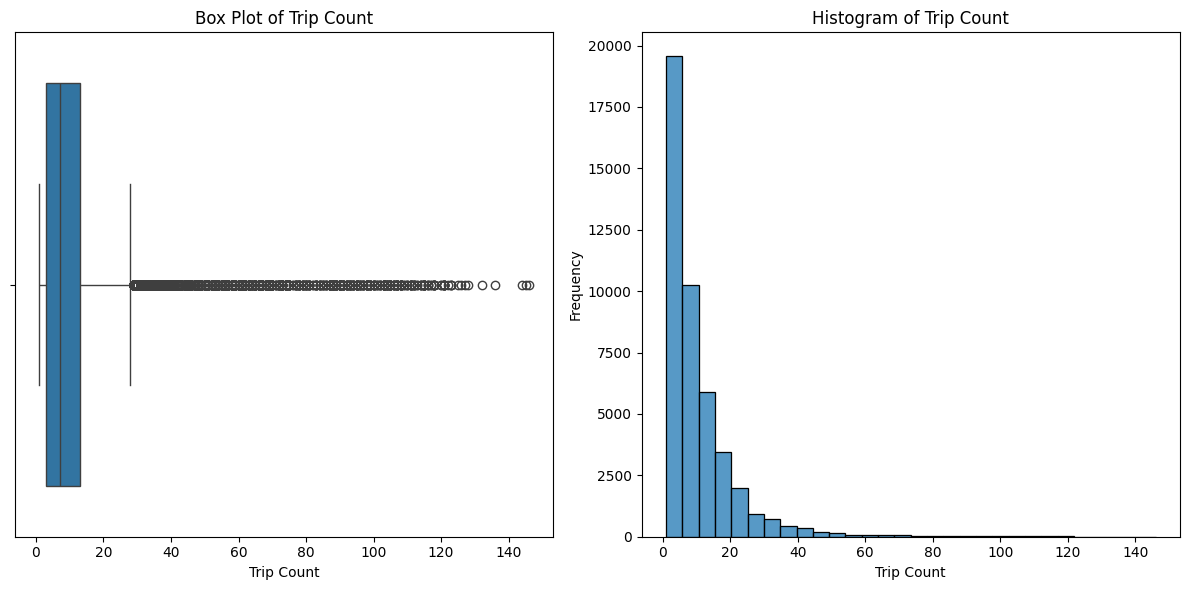

In [37]:
# Box Plot for Trip Count
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.boxplot(x=df['trip_count'])
plt.title('Box Plot of Trip Count')
plt.xlabel('Trip Count')

# Histogram for Trip Count
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df['trip_count'], bins=30, kde=False)  
plt.title('Histogram of Trip Count')
plt.xlabel('Trip Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Remove extreme outliers for Daily Trip Count per Station

As shown in the the boxplot there are a significant number of outliers that should be removed before proceeding with the modeling effort

count    41880.000000
mean         8.001480
std          6.512805
min          1.000000
25%          3.000000
50%          6.000000
75%         12.000000
max         28.000000
Name: trip_count, dtype: float64


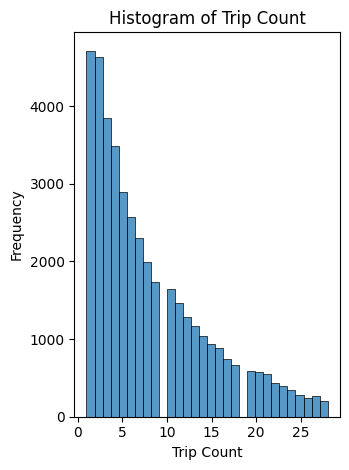

In [38]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for 'trip_count' using IQR method
df_cleaned = remove_outliers_iqr(df, 'trip_count')

# Check the cleaned data
print(df_cleaned['trip_count'].describe())

# Histogram for Trip Count
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df_cleaned['trip_count'], bins=30, kde=False) 
plt.title('Histogram of Trip Count')
plt.xlabel('Trip Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Encode categorical variables and create transformed dataframe to prepare data from processing through model

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# start_station_id, start_region_id, month, trip_count, avg_dow_trips, avg_temp_dist, precipitation_dist, windspeed_dist

# Define the features for numerical scaling and categorical encoding
numerical_features = ['trip_count', 'avg_dow_trips', 'avg_temp_dist', 'precipitation_dist', 'windspeed_dist']
categorical_features = ['start_station_id', 'start_region_id', 'month']

# Define the preprocessor without numerical scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # Pass through numerical features without scaling
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Apply the transformations
X_transformed = preprocessor.fit_transform(df_cleaned)
feature_names = preprocessor.get_feature_names_out()

# Ensure the transformed data and feature names match in dimension
assert X_transformed.shape[1] == len(feature_names), "Mismatch between transformed columns and feature names"

# Create the transformed DataFrame
df_transformed = pd.DataFrame(X_transformed.toarray(), columns=feature_names)

#### Define target variable, features and split dataset into training and testing groups

In [20]:
# Define the target variable and features
target_variable = 'num__trip_count'
X = df_transformed.drop(columns=[target_variable])
y = df_transformed[target_variable]

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Ensure that the test set contains the relevant features (station_id and date)
X_test = X_test.merge(df_cleaned[['start_station_id', 'date']], left_index=True, right_index=True)


#### Run training data through Random Forest model, test the performance of the trained model and visualize actual vs predicted values

Random Forest Regression - MSE: 9.507738952562878, R-squared: 0.7724116403607573


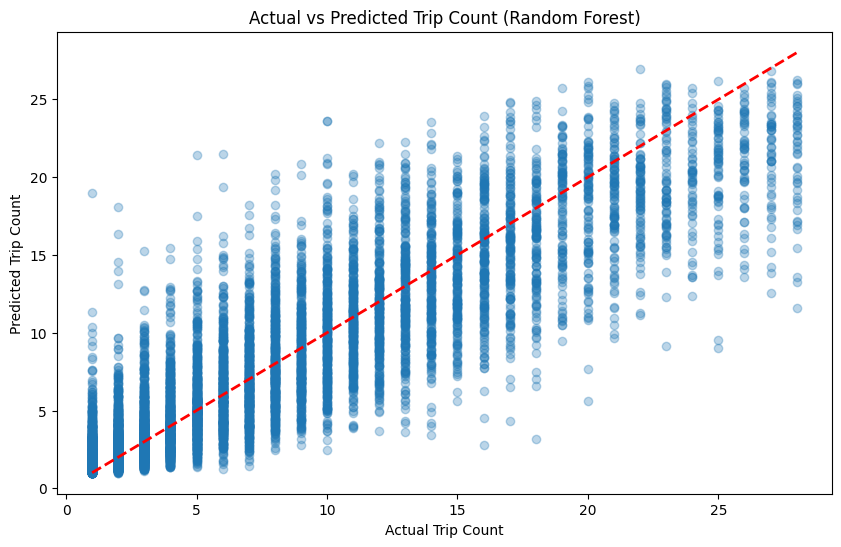

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test.drop(columns=['start_station_id', 'date']))

# Evaluate the model's performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation metrics
print(f"Random Forest Regression - MSE: {mse_rf}, R-squared: {r2_rf}")

# Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Trip Count')
plt.ylabel('Predicted Trip Count')
plt.title('Actual vs Predicted Trip Count (Random Forest)')
plt.show()


#### Construct a new cleaned dataframe from the predicted values to visualize the performance of the model and operationalilze the data

In [27]:
# Create a DataFrame to store actual and predicted values along with relevant features
df_predictions = X_test.copy()
df_predictions['actual_trip_count'] = y_test.values
df_predictions['predicted_trip_count'] = y_pred_rf

# Drop the unnecessary transformed categorical variables
unnecessary_columns = df_predictions.columns.difference(['start_station_id', 'date', 'actual_trip_count', 'predicted_trip_count'])
df_predictions = df_predictions.drop(columns=unnecessary_columns)

# Display the first few rows of the DataFrame to ensure it has the desired structure
print(df_predictions.head())


       start_station_id        date  actual_trip_count  predicted_trip_count
216                 183  2018-03-18               12.0                 13.00
28361                99  2018-01-23               10.0                 17.04
37577               201  2017-10-16               11.0                 14.42
25387               209  2018-01-24                2.0                  1.16
7817                160  2017-10-13               11.0                 12.12


#### Show a sampling of the prediction data to demonstrate model quality and visualize the variance between actual vs predicted counts in a histogram

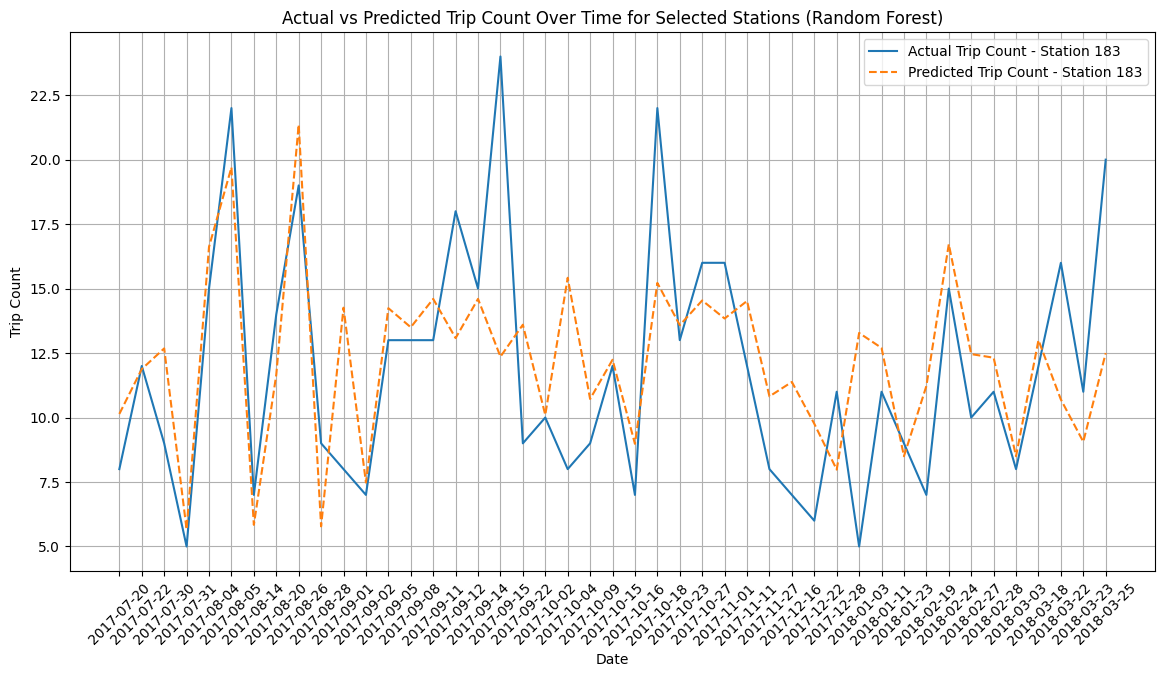

Bike Distribution Plan Example:
   start_station_id        date  predicted_trip_count
0                15  2017-12-16                 22.16
1                15  2017-12-30                 15.42
2                17  2017-07-22                 13.76
3                17  2017-07-30                  8.08
4                17  2017-08-05                 19.20
Summary Statistics for 'Difference' Between Actual and Predicted Trip Counts:
count    8376.000000
mean        0.049639
std         3.083247
min       -18.000000
25%        -1.505000
50%        -0.080000
75%         1.600000
max        16.440000
Name: difference, dtype: float64


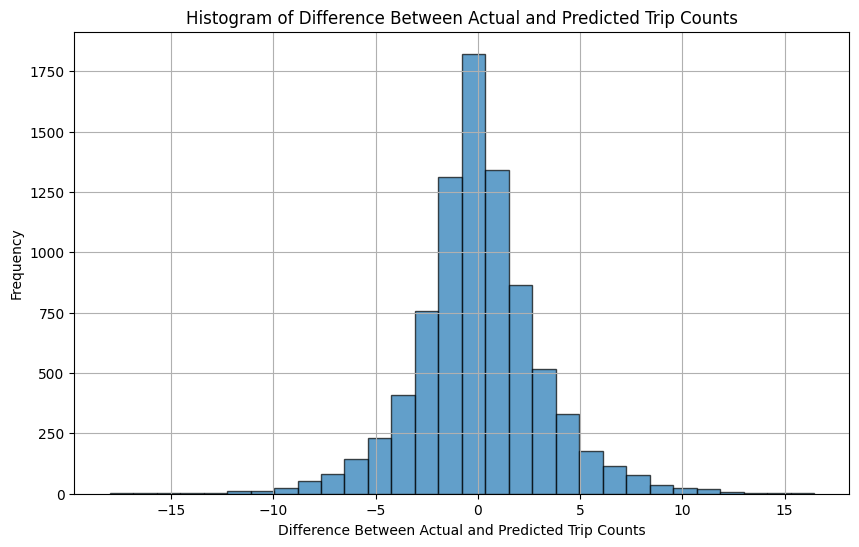

In [35]:
# Select a limited number of stations for better visualization
selected_stations = df_predictions['start_station_id'].unique()[:1]
df_predictions_limited = df_predictions[df_predictions['start_station_id'].isin(selected_stations)]

df_predictions_limited = df_predictions_limited.sort_values(by='date').head(45)

# Plotting the actual vs predicted values over time for each station
plt.figure(figsize=(14, 7))

for station_id in selected_stations:
    df_station = df_predictions_limited[df_predictions_limited['start_station_id'] == station_id]
    plt.plot(df_station['date'], df_station['actual_trip_count'], label=f'Actual Trip Count - Station {station_id}')
    plt.plot(df_station['date'], df_station['predicted_trip_count'], '--', label=f'Predicted Trip Count - Station {station_id}')

plt.xlabel('Date')
plt.ylabel('Trip Count')
plt.title('Actual vs Predicted Trip Count Over Time for Selected Stations (Random Forest)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Displaying the operational decision-making examples

# Bike Distribution Plan
predicted_demand = df_predictions.groupby(['start_station_id', 'date']).agg({
    'predicted_trip_count': 'sum'
}).reset_index()
print("Bike Distribution Plan Example:")
print(predicted_demand.head(5))

# Dynamic Rebalancing Example
actual_vs_predicted = df_predictions.copy()
actual_vs_predicted['difference'] = actual_vs_predicted['actual_trip_count'] - actual_vs_predicted['predicted_trip_count']

# Display summary statistics for the 'difference' column
difference_summary = actual_vs_predicted['difference'].describe()
print("Summary Statistics for 'Difference' Between Actual and Predicted Trip Counts:")
print(difference_summary)

# Plotting the histogram for 'difference'
plt.figure(figsize=(10, 6))
plt.hist(actual_vs_predicted['difference'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Difference Between Actual and Predicted Trip Counts')
plt.ylabel('Frequency')
plt.title('Histogram of Difference Between Actual and Predicted Trip Counts')
plt.grid(True)
plt.show()
